In [1]:
import math
from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F
from data import Celeba
from torchvision import transforms as T

/home/khw5218/miniconda3/envs/diffusion/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# parameters
dataroot = "./data/celeba/"
img_dir = dataroot + "image/"
annotation = dataroot + "anno/"
image_size = 28
channels = 3
batch_size = 128

In [3]:
# Utils

def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d
# 값이 있으면 val 값 return, 없다면 d가 함수인지 보고 
# 함수일 때 d(val) 값 return
# 상수일 때 d return

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x



def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

# input과 Output의 Channel 수는 동일하지만 크기(Resolution)가 커짐

def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)

# input과 Output의 Channel 수는 동일하지만 크기(Resolution)가 작아짐

In [4]:
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x
    
# input: N dim H W
# Output: N dim_out H W

# 간단한 Cov -> GroupNorm -> Activation 구조

In [5]:
# Block Test
noise = torch.randn(1, 32, 28, 28)  # N(Batch Size) C H W
print(noise.shape)
test_network = Block(32, 32)
result = test_network(noise)
print(result.shape)




torch.Size([1, 32, 28, 28])
torch.Size([1, 32, 28, 28])


In [6]:
class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""
    
    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.block1(x)

        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h

        h = self.block2(h)
        return h + self.res_conv(x)
    
# input: N dim H W
# Output: N dim_out H W

# input() -> Block(dim, dim_out) -> Block(dim_out, dim_out) ->  output
#  \>                Res_Conv(dim, dim_out)            />

In [7]:
# ResnetBlock Test
noise = torch.randn(1, 32, 28, 28)  # N(Batch Size) C H W
print(noise.shape)
test_network = ResnetBlock(32, 16)
result = test_network(noise)
print(result.shape)

noise = torch.randn(1, 32)  # N(Batch Size) C H W
print(noise.size())
noise = rearrange(noise, "b c -> b c 1 1")
print(noise.size())

torch.Size([1, 32, 28, 28])
torch.Size([1, 16, 28, 28])
torch.Size([1, 32])
torch.Size([1, 32, 1, 1])


In [8]:
class ConvNextBlock(nn.Module):
    """https://arxiv.org/abs/2201.03545"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, mult=2, norm=True):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.GELU(), nn.Linear(time_emb_dim, dim))
            if exists(time_emb_dim)
            else None
        )

        self.ds_conv = nn.Conv2d(dim, dim, 7, padding=3, groups=dim)

        self.net = nn.Sequential(
            nn.GroupNorm(1, dim) if norm else nn.Identity(),
            nn.Conv2d(dim, dim_out * mult, 3, padding=1),
            nn.GELU(),
            nn.GroupNorm(1, dim_out * mult),
            nn.Conv2d(dim_out * mult, dim_out, 3, padding=1),
        )

        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.ds_conv(x)

        if exists(self.mlp) and exists(time_emb):
            assert exists(time_emb), "time embedding must be passed in"
            condition = self.mlp(time_emb)
            h = h + rearrange(condition, "b c -> b c 1 1")

        h = self.net(h)
        return h + self.res_conv(x)
    
# ResConnection과 Block이 합쳐진 형태 + Image를 크게 인식
# input: N dim H W
# output: N dim_out * mult H W (Res Conv)

In [9]:
# ConvNextBlock Test

noise = torch.randn(1, 32, 28, 28)  # N(Batch Size) C H W
print(noise.shape)
test_network = ConvNextBlock(32, 16)
result = test_network(noise)
print(result.shape)


torch.Size([1, 32, 28, 28])
torch.Size([1, 16, 28, 28])


In [10]:
a = torch.ones(1, 1, 3, 4) * 2 # N(Batch Size) C H W
b = torch.ones(1, 1, 3, 4) * 3 # N(Batch Size) C H W
print(a)
print(b)

out = einsum("b h d i, b h d j -> b h i j", a, b)
print(out)
print(out.shape)

# print(noise.shape)
# test_network = ConvNextBlock(32, 16)
# result = test_network(noise)
# print(result.shape)

tensor([[[[2., 2., 2., 2.],
          [2., 2., 2., 2.],
          [2., 2., 2., 2.]]]])
tensor([[[[3., 3., 3., 3.],
          [3., 3., 3., 3.],
          [3., 3., 3., 3.]]]])
tensor([[[[18., 18., 18., 18.],
          [18., 18., 18., 18.],
          [18., 18., 18., 18.],
          [18., 18., 18., 18.]]]])
torch.Size([1, 1, 4, 4])


In [11]:
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)
    
# self attention 층
# input: N dim H W
# Output: N dim H W (Context 정보를 담고 있음)

In [12]:
# Attention Test

noise = torch.randn(1, 32, 28, 28)  # N(Batch Size) C H W
print(noise.shape)
test_network = Attention(32)
result = test_network(noise)
print(result.shape)

torch.Size([1, 32, 28, 28])
torch.Size([1, 32, 28, 28])


In [13]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

# 미리 Group Norm 해주는 Module

In [14]:
class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), 
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)
    
# Linear attention 층
# input: N dim H W
# Output: N dim H W (Context 정보를 담고 있음)

In [15]:
# LinearAttention Test

noise = torch.randn(1, 32, 28, 28)  # N(Batch Size) C H W
print(noise.shape)
test_network = LinearAttention(32)
result = test_network(noise)
print(result.shape)

torch.Size([1, 32, 28, 28])
torch.Size([1, 32, 28, 28])


In [16]:
# Positional Embed
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [17]:
# Positional Embedding 

device = "cuda" if torch.cuda.is_available() else "cpu"
t = torch.randint(0, 200, (batch_size,), device=device).long()
print(t)
print("t size: {}".format(t.size()))
test_emb = SinusoidalPositionEmbeddings(28)

print(test_emb(t))
print("embedded t size: {}".format(test_emb(t).size()))


dim = 28
time_dim = dim * 4
t = torch.randint(0, 200, (batch_size,))
test_nn = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),
                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )
emb_t = test_nn(t)
print(emb_t.size())



tensor([ 89,  85, 110,  50,  41,  67,  48, 188, 110,  52, 185,  17,  60, 175,
        101,  24, 161, 156, 118, 196, 149, 150, 184, 102, 158,  52, 125, 197,
        103,  67, 120, 128, 191, 146,  77,  22,  64, 165, 124, 197,  41, 116,
        149,  62, 179,  98, 197, 181, 118,  18,  71, 151,  36, 109,   0, 137,
        178,  50,   9,   0,  24, 164,  96,  24,  86, 191,  18,   8,  81,  30,
         91,  96,  96,  34,  21, 113,  32, 190, 189, 157,  54,  77, 158,   3,
        178, 160, 117, 180,  88,  95,  10,  20,   9, 100, 115, 179, 138,  81,
        184, 102,  26, 152,  34,  71,  95, 193,  49,  25,  85, 158,  16, 186,
        117, 178,  67, 125,   4,  62, 172,  10,  37, 140, 121,  60,  76,  53,
        139,  54], device='cuda:0')
t size: torch.Size([128])
tensor([[ 0.8601, -0.1591,  0.4018,  ...,  0.9993,  0.9998,  1.0000],
        [-0.1761, -0.8481,  0.9825,  ...,  0.9994,  0.9999,  1.0000],
        [-0.0442, -0.6857,  0.9994,  ...,  0.9990,  0.9998,  0.9999],
        ...,
        [ 0.3

In [18]:
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        with_time_emb=True,
        resnet_block_groups=8,
        use_convnext=True,
        convnext_mult=2,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2)
        
        print("init_dim: {}".format(init_dim))
        
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)
        # (B, init_dim, H, W)
        
        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))
        
        
        print("dims: {}".format(dims))
        print("in_out: {}".format(in_out))
        
        # init_dim: 36
        # dims: [36, 56, 112, 224]
        # in_out: [(36, 56), (56, 112), (112, 224)]
        
        if use_convnext:
            block_klass = partial(ConvNextBlock, mult=convnext_mult)
        else:
            block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),
                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )
        else:
            time_dim = None
            self.time_mlp = None

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )

    def forward(self, x, time):
        x = self.init_conv(x)
        t = self.time_mlp(time) if exists(self.time_mlp) else None
        h = []
        print("Init: {}".format(x.size()) )
        # downsample
        for block1, block2, attn, downsample in self.downs:
            
            x = block1(x, t)
            print("Down1 After: {}".format(x.size()) )
            x = block2(x, t)
            print("Down2 After: {}".format(x.size()) )
            x = attn(x)
            print("Down3(Attention) After = h: {}".format(x.size()) )
            h.append(x)
            x = downsample(x)
            print("Down4 After: {}".format(x.size()) )

        # bottleneck
        x = self.mid_block1(x, t)
        print("Mid1: {}".format(x.size()) )
        x = self.mid_attn(x)
        print("Mid2(Attention): {}".format(x.size()) )
        x = self.mid_block2(x, t)
        print("Mid3: {}".format(x.size()) )

        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            print("Up1(concat): {}".format(x.size()) )
            x = block1(x, t)
            print("Up1: {}".format(x.size()) )
            x = block2(x, t)
            print("Up2: {}".format(x.size()) )
            x = attn(x)
            print("Up3(attention): {}".format(x.size()) )
            x = upsample(x)
            print("Up4: {}".format(x.size()) )
        return self.final_conv(x)

In [19]:
# 1. Conv Layer가 각 batch 별 Noisy image에 적용된다. (Positional Embedding 은 해당 Noise Level에 대해 계산된다.)
# 2. Down Sampling 과정이 적용된다. 각 Down Sampling 구성 = {2 * Resnet/Conv + GroupNorm + Attention + Residual Connection + Downsampling Oper}
# 
# 3. Up Sampling 과정이 적용된다. 각 Up Sampling 구성 = {2 * Resnet/Conv + GroupNorm + Attention + Residual Connection + Upwnsampling Oper}

In [20]:
# UNet Test
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

noise = torch.randn((128, 3, 28, 28), device=device)  # N(Batch Size) C H W
t = torch.randint(0, 100, (128,), device=device).long()
print(noise.device)
test_network = Unet(
        28,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4),
        channels=3,
        with_time_emb=True,
        resnet_block_groups=8,
        use_convnext=True,
        convnext_mult=2,
    )
test_network.to(device)
result = test_network(noise, t)
print(result.shape)

cuda
cuda:0
init_dim: 18
dims: [18, 28, 56, 112]
in_out: [(18, 28), (28, 56), (56, 112)]
Init: torch.Size([128, 18, 28, 28])
Down1 After: torch.Size([128, 28, 28, 28])
Down2 After: torch.Size([128, 28, 28, 28])
Down3(Attention) After = h: torch.Size([128, 28, 28, 28])
Down4 After: torch.Size([128, 28, 14, 14])
Down1 After: torch.Size([128, 56, 14, 14])
Down2 After: torch.Size([128, 56, 14, 14])
Down3(Attention) After = h: torch.Size([128, 56, 14, 14])
Down4 After: torch.Size([128, 56, 7, 7])
Down1 After: torch.Size([128, 112, 7, 7])
Down2 After: torch.Size([128, 112, 7, 7])
Down3(Attention) After = h: torch.Size([128, 112, 7, 7])
Down4 After: torch.Size([128, 112, 7, 7])
Mid1: torch.Size([128, 112, 7, 7])
Mid2(Attention): torch.Size([128, 112, 7, 7])
Mid3: torch.Size([128, 112, 7, 7])
Up1(concat): torch.Size([128, 224, 7, 7])
Up1: torch.Size([128, 56, 7, 7])
Up2: torch.Size([128, 56, 7, 7])
Up3(attention): torch.Size([128, 56, 7, 7])
Up4: torch.Size([128, 56, 14, 14])
Up1(concat): torc

In [21]:
# forward diffusion process

In [21]:
# beta scheduling 
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

In [22]:
# forward util
timesteps = 200

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)
print("betas size: {}".format(betas.size()))
# (timestamp,)

# define alphas 
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)  
print("alphas_cumprod size: {}".format(alphas_cumprod.size()))



alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0) # 맨 뒷부분 하나 자르고 앞부분에 1 추가
print("alphas_cumprod_prev size: {}".format(alphas_cumprod_prev.size()))

sqrt_recip_alphas = torch.sqrt(1.0 / alphas)    # Backward Process 시 사용

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
print("sqrt_alphas_cumprod size: {}".format(sqrt_alphas_cumprod.size()))

sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
print("sqrt_one_minus_alphas_cumprod size: {}".format(sqrt_one_minus_alphas_cumprod.size()))

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)  # Backward Process 시 사용
def extract(a, t, x_shape): # batch index에 대한 적절한 T를 추출하는 방법
    # a: 원하는 변수 ex) beta, alpha 등
    # t: (batch_size, ) 0 ~ timestamp 사이 정수 중 랜덤하게 Batch Size 만큼 추출한 것
    # t = torch.randint(0, timesteps, (batch_size,), device=device).long()
    # x_shape: (batch_size, channels, H, W)
    # ex) extract(sqrt_alphas_cumprod, t, x_start.shape)
    
    # F.pad() 의 의미 
    
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu()) 
    # t = [timestamp_1, timestamp_2, ..., timestamp_t]
    # a = [a_1, a_2, ... , a_timesteps]
    # a 중에서 각 t의 원소, 즉 time stamp에 해당하는 값들을 뽑는다.
    
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)   # N C H W 형식 맞추려고 뒤에 차원 추가하여 GPU load

betas size: torch.Size([200])
alphas_cumprod size: torch.Size([200])
alphas_cumprod_prev size: torch.Size([200])
sqrt_alphas_cumprod size: torch.Size([200])
sqrt_one_minus_alphas_cumprod size: torch.Size([200])


In [23]:
a = torch.tensor([1,2,3,4])
print(a)
b = F.pad(a[:-1], (1, 0), value=1.0) # 맨 앞부분만 1로 채움
print(b)


tensor([1, 2, 3, 4])
tensor([1, 1, 2, 3])


In [24]:
# image transformations
transforms_a = T.Compose([
    T.ToTensor(),
    T.Resize((image_size, image_size)),
    T.RandomHorizontalFlip(),
    # T.Normalize((0.5), (0.5))# T.Normalize([0.5],[0.5])
])

In [25]:
transforms_b = T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(), # turn into Numpy array of shape HWC, divide by 255
    T.Lambda(lambda t: (t * 2) - 1),
])

In [26]:
from PIL import Image
import requests
# # parameters
# dataroot = "./data/celeba/"
# img_dir = dataroot + "image/"
# annotation = dataroot + "anno/"
# image_size = 64
# channels = 3
# batch_size = 128

idx = 10
url = img_dir + "{0:0>6}.png".format(idx)
image = Image.open(url)
image = transforms_b(image)
# plt.imshow(image)


In [27]:
import numpy as np

reverse_transform = T.Compose([
    T.Lambda(lambda t: (t + 1) / 2),
    T.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
    T.Lambda(lambda t: t * 255.),
    T.Lambda(lambda t: t.numpy().astype(np.uint8)),
    T.ToPILImage(),
])

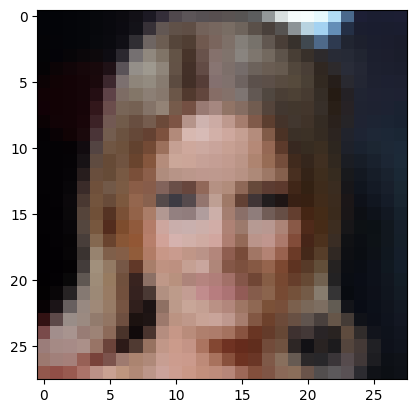

In [28]:
plt.imshow(reverse_transform(image.squeeze()))

In [29]:
# forward diffusion

# input 
# x_start(원본 이미지)
# x 
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

In [30]:
def get_noisy_image(x_start, t):
  # add noise
  x_noisy = q_sample(x_start, t=t)

  # turn back into PIL image
  noisy_image = reverse_transform(x_noisy.squeeze())

  return noisy_image

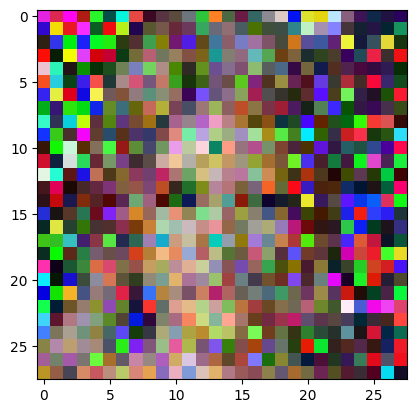

In [31]:
# take time step
t = torch.tensor([40])

plt.imshow(get_noisy_image(image, t))

In [32]:
import matplotlib.pyplot as plt

# use seed for reproducability
torch.manual_seed(0)

# source: https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [image] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [33]:
plot([get_noisy_image(image, torch.tensor([t])) for t in [0, 50, 100, 150, 199]])

In [34]:
# Sampling Methods

@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    
    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

# Algorithm 2 but save all images:
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []
    
    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))

In [35]:
# loss

def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    # 원본에 Noise를 넣어 Noisy한 Image를 만듦
    predicted_noise = denoise_model(x_noisy, t)
    # Noise 예측 

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

In [36]:
def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr


In [37]:
divisor = 128
num = 4
result = num_to_groups(num, divisor)
print(result)

[4]


In [54]:
t = torch.randn((2, 3))
t = torch.cat(t, dim = 0)
t

TypeError: cat() received an invalid combination of arguments - got (Tensor, dim=int), but expected one of:
 * (tuple of Tensors tensors, int dim, *, Tensor out)
 * (tuple of Tensors tensors, name dim, *, Tensor out)


In [50]:
from pathlib import Path

results_folder = Path("./results")
results_folder.mkdir(exist_ok = True)
save_and_sample_every = 1000

model_save_dir = Path("./checkpoint_scratch/")
results_folder.mkdir(exist_ok = True)

In [42]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

init_dim: 18
dims: [18, 28, 56, 112]
in_out: [(18, 28), (28, 56), (56, 112)]


In [48]:
# training process

from torchvision.utils import save_image
from torch.utils.data import DataLoader
from data import Celeba

dataset = Celeba(img_dir, None, transforms=transforms_b, mode="train")
dataloader = DataLoader(dataset, batch_size= batch_size, shuffle= True)
# img = next(iter(dataloader))
# print(img.size())


for i, img in enumerate(dataloader):
    if i == 5: break
    print("i: {}".format(i))
    print("img size: {}".format(img.size()))
    

i: 0
img size: torch.Size([128, 3, 28, 28])
i: 1
img size: torch.Size([128, 3, 28, 28])
i: 2
img size: torch.Size([128, 3, 28, 28])
i: 3
img size: torch.Size([128, 3, 28, 28])
i: 4
img size: torch.Size([128, 3, 28, 28])


In [49]:
# training process

from torchvision.utils import save_image
from torch.utils.data import DataLoader
from data import Celeba
from torch.utils.tensorboard import SummaryWriter

dataset = Celeba(img_dir, None, transforms=transforms_b, mode="train")
dataloader = DataLoader(dataset, batch_size= batch_size, shuffle= True)
epochs = 5

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      batch_size = batch.shape[0]
      batch = batch.to(device)

      # Algorithm 1 line 3: sample t uniformally for every example in the batch
      t = torch.randint(0, timesteps, (batch_size,), device=device).long()

      loss = p_losses(model, batch, t, loss_type="huber")

      if step % 100 == 0: # batch size 128 기준 약 1271 iteration
        print("Loss:", loss.item())
        # model save
        torch.save({
            'batch_size': batch_size,
            'step': step,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, model_save_dir+"step{0:0>3}_model.tar".format(e))

      loss.backward()
      optimizer.step()

      # save generated images
      if step != 0 and step % save_and_sample_every == 0:
        milestone = step // save_and_sample_every
        batches = num_to_groups(4, batch_size)  # 4 > batchsize 이면 2개 이상 
        all_images_list = list(map(lambda n: sample(model, batch_size=n, channels=channels), batches))
        all_images = torch.cat(all_images_list, dim=0)
        all_images = (all_images + 1) * 0.5
        save_image(all_images, str(results_folder / f'sample-{milestone}.png'), nrow = 6)
        
        
        
        

Loss: 0.47973620891571045
Loss: 0.2370518445968628
Loss: 0.09435836225748062
Loss: 0.06448941677808762
Loss: 0.05321143567562103
Loss: 0.05265253782272339
Loss: 0.04738089069724083
Loss: 0.04795907437801361
Loss: 0.04483916237950325
Loss: 0.04500192776322365


FileNotFoundError: [Errno 2] No such file or directory: './data/celeba/image/000000.png'